## Workflow for this CNN project

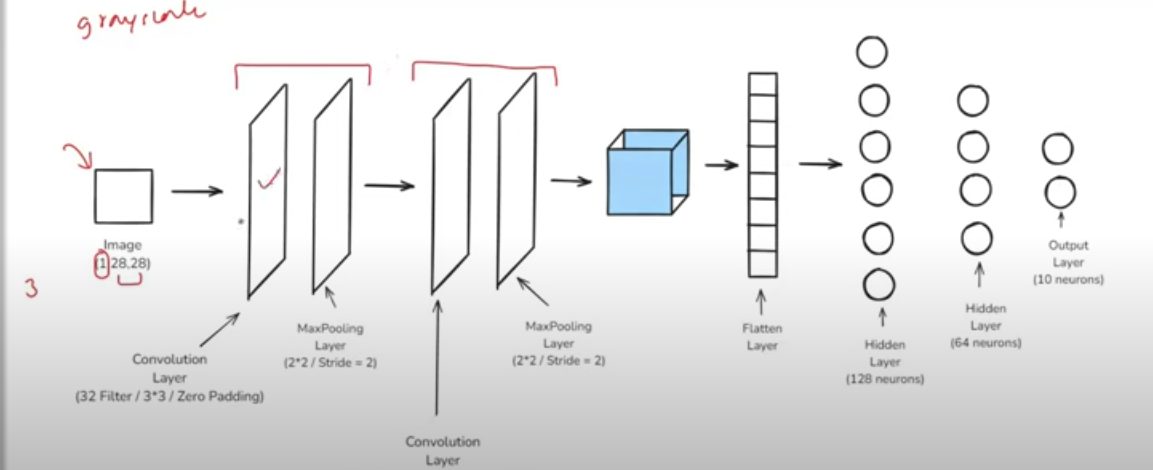

1. Convolution Layer
Think of it like a small window (called a filter or kernel) that slides over the image.

It looks at a few pixels at a time and computes a dot product between the filter and the image patch.

This creates a feature map — a new image showing where that pattern was found.

🔍 Example:
If the filter is for detecting vertical edges, it will highlight all the vertical lines in the image.

2. Strides
It means how much the filter moves at a time when scanning the image.

Stride = 1 → move the filter 1 pixel at a time (detailed).

Stride = 2 or more → move faster, get smaller output (less detail, but faster).

3. Padding
When filters go near the edge of the image, they can’t fully overlap.

Padding adds extra pixels (usually zeros) around the image to keep the size consistent.

Types:

Valid → no padding, output gets smaller.

Same → adds padding to keep the same size.

4. Pooling Layer
Downsamples the image to make it smaller and focus on the most important parts.

Common type: Max Pooling

Looks at a small patch and keeps the maximum value (strongest signal).

Helps to:

Reduce size and computation

Keep only strong features

Add some translation resistance (e.g., object shifted a bit)

🔁 Think of pooling like shrinking an image while keeping the important stuff.

5. Flatten
Converts the final 2D feature maps into a 1D vector.

This is needed before feeding it into fully connected layers (like in regular neural nets).

6. Fully Connected Layers (Dense)
Just like layers in a normal neural network.

They take the extracted features and make a final prediction (like "cat" or "dog").

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


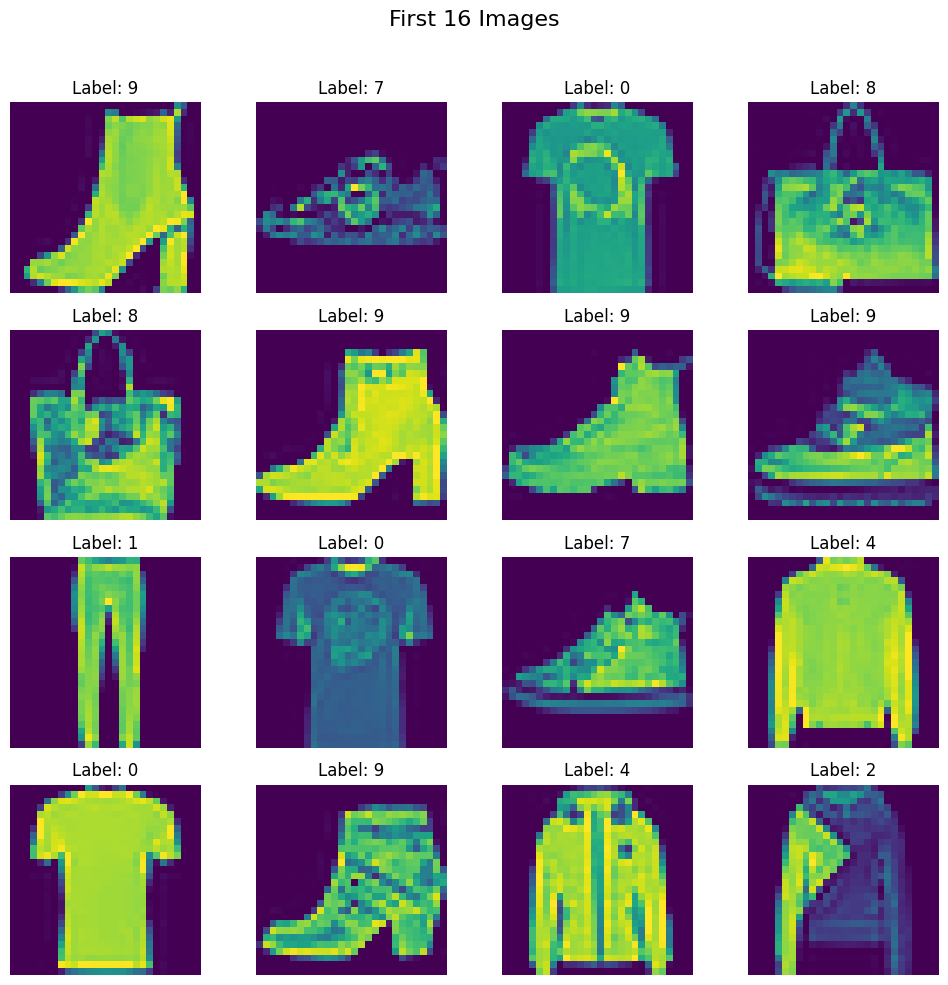

In [5]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


In [6]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# scaling the feautures
X_train = X_train/255.0
X_test = X_test/255.0

In [9]:
class MyDataset(Dataset):
  def __init__(self,features,labels):
    self.features = torch.tensor(features,dtype=torch.float32).reshape(-1,1,28,28)
    # reshape( batchsize, channels ,length ,width )
    self.labels = torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self,index):
    return self.features[index], self.labels[index]

In [18]:
training_data = MyDataset(X_train,y_train)
test_data = MyDataset(X_test,y_test)

In [11]:
class MyNN(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.features = nn.Sequential(
        nn.Conv2d(num_features,32,kernel_size = 3,padding = "same"),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size = 3, stride=2),
        nn.Conv2d(32 , 64 ,kernel_size = 3,padding = "same"),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size = 3, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(64*7*7,128),
        nn.ReLU(),
        nn.Dropout(p = 0.4),

        nn.Linear(128,64),
        nn.ReLU(),
        nn.Dropout(p = 0.4),
        nn.Linear(64,10)
    )

  def forward(self,x):
    x = self.features(x)
    return self.classifier(x)

In [12]:
learning_rate = 0.01
epochs = 100

In [13]:
model = MyNN(1)
model.to(device)

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.SGD(model.parameters(), lr= learning_rate)

In [19]:
train_loader = DataLoader(training_data, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, pin_memory=True)

In [21]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


Epoch: 1 , Loss: 1.421520808537801
Epoch: 2 , Loss: 0.8235707771778107
Epoch: 3 , Loss: 0.6747879642248154
Epoch: 4 , Loss: 0.586284062465032
Epoch: 5 , Loss: 0.5301214645306269
Epoch: 6 , Loss: 0.47537423382202787
Epoch: 7 , Loss: 0.4377516756455104
Epoch: 8 , Loss: 0.3918151651819547
Epoch: 9 , Loss: 0.3539867794016997
Epoch: 10 , Loss: 0.3255325445532799
Epoch: 11 , Loss: 0.30234651202956836
Epoch: 12 , Loss: 0.2827304539084434
Epoch: 13 , Loss: 0.2557393862307072
Epoch: 14 , Loss: 0.2226710803558429
Epoch: 15 , Loss: 0.20324998947481315
Epoch: 16 , Loss: 0.1874946563442548
Epoch: 17 , Loss: 0.1732590401917696
Epoch: 18 , Loss: 0.15988577734678983
Epoch: 19 , Loss: 0.14517826497554778
Epoch: 20 , Loss: 0.1272287336240212
Epoch: 21 , Loss: 0.11623577047760288
Epoch: 22 , Loss: 0.10256596604983012
Epoch: 23 , Loss: 0.09567781761909525
Epoch: 24 , Loss: 0.09772785815099876
Epoch: 25 , Loss: 0.08854686950022976
Epoch: 26 , Loss: 0.0767997802545627
Epoch: 27 , Loss: 0.0680825935676694
Ep

In [22]:
# set model to eval mode
model.eval()

MyNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [26]:
# evaluation on training data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total * 100,"%")

99.89583333333333 %
